# Exploratory Data Analysis

In [1]:
import os 
import torch

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import BallTree
from dgl.geometry import farthest_point_sampler
from datachallengecode import load_data
from datachallengecode import metric

In [2]:
class2idx = {
    "background": 0,
    "beams": 1,
    "cabletrays": 2,
    "civils": 3,
    "gratings": 4,
    "guardrails": 5,
    "hvac": 6,
    "ladders": 7,
    "piping": 8,
    "supports": 9,
}

In [3]:
data_path = "data"

ytrain_path = os.path.join(data_path, "ytrain.csv")
xtrain_path = os.path.join(data_path, "xtrain")

## Classes

In [4]:
y = load_data.load_yfile(ytrain_path)

y.shape

(130661990,)

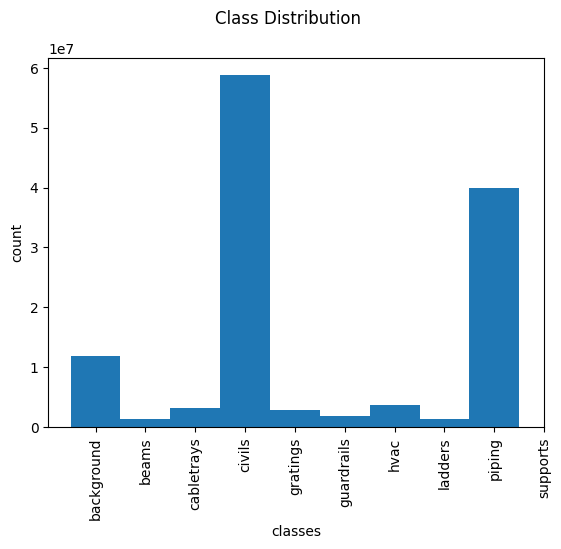

In [5]:
fig, ax = plt.subplots()

ax.hist(y, bins=np.arange(len(class2idx))-0.5)

ax.set_xticks(range(len(class2idx)))
ax.set_xticklabels(class2idx, rotation=90)
ax.set_xlabel("classes")
ax.set_ylabel("count")
fig.suptitle("Class Distribution")

plt.show()

In [6]:
print(f"The percentage of civils in the training data is {y[y == class2idx['civils']].shape[0] / y.shape[0]}")

The percentage of civils in the training data is 0.44953724491720964


In [7]:
y_score = np.zeros_like(y) + class2idx["civils"]

score = metric.mean_average_presicion_score(y, y_score, len(class2idx))

print(f"The score that we would get with the benchmark model on the training data is {score}")

The score that we would get with the benchmark model on the training data is 0.2788251702760454


In [8]:
print("Compared to the score from the benchmark 0.3226")

Compared to the score from the benchmark 0.3226


## Point Cloud Data

In [9]:
_, x_0 = load_data.read_x_plyfile(os.path.join(xtrain_path, "SCAN_0.ply"))

x_0.shape

(2368290, 7)

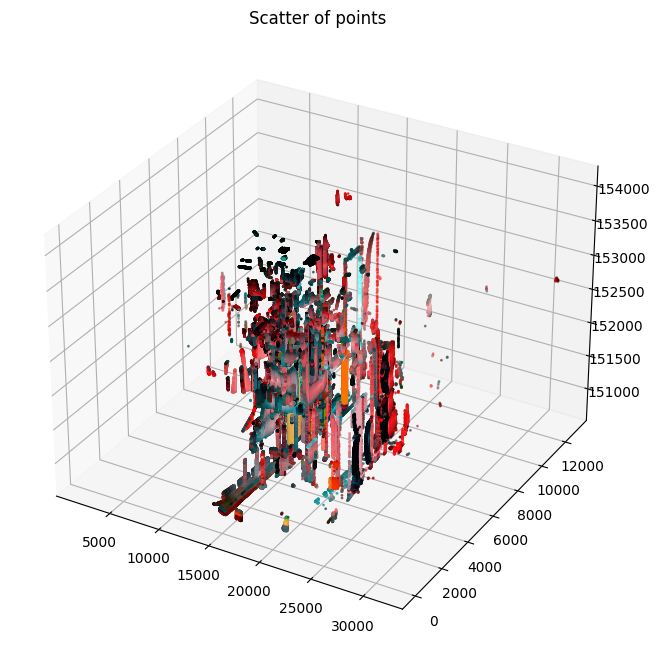

In [10]:
x_sample = x_0

x_sample_pos = x_sample[:, :3]
x_sample_rgb = x_sample[:, 3:6] / 255.0
x_sample_int = x_sample[:, 6:] / 255.0

x = x_sample_pos[:, 0]
y = x_sample_pos[:, 1]
z = x_sample_pos[:, 2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c=x_sample_rgb, s=1)

plt.title("Scatter of points")
plt.show()

In PointNet++ the sampling method for the points is done using farthest point sampler (FPS). This was compared to random point sampling and had better results. The sampling is used as a replacement for the max pooling layer of the original PointNet architecture, to create an encoder block architecture. The architecture follows:

1. sampling
2. grouping
3. pointnet

The sampling step chooses the centroids that will be used, the grouping selects the neighboring points for each centroid. Again they used two methods: ball query and K nearest neighbor (kNN). Ball query had the better results for the task of segmentation.

The pointnet step will compute the feature vector for each centroid based on the neighborhood of that centroid, resulting in a smaller number of points and higher number of features. The input to this encoder block is of size Nx(d+C) and the output is of size N'x(d+C'), where N is the input number of points, and N' is the output number of points, d is the dimensionality of the position features and C/C' are the input/output features.

### Sampling FPS

In [11]:
x = torch.from_numpy(x_0[:, :3]).view(1, -1, 3)

point_idx = farthest_point_sampler(x, 2000)

point_idx

tensor([[  26392, 1598258,  307495,  ..., 1422861, 1857973, 1380863]])

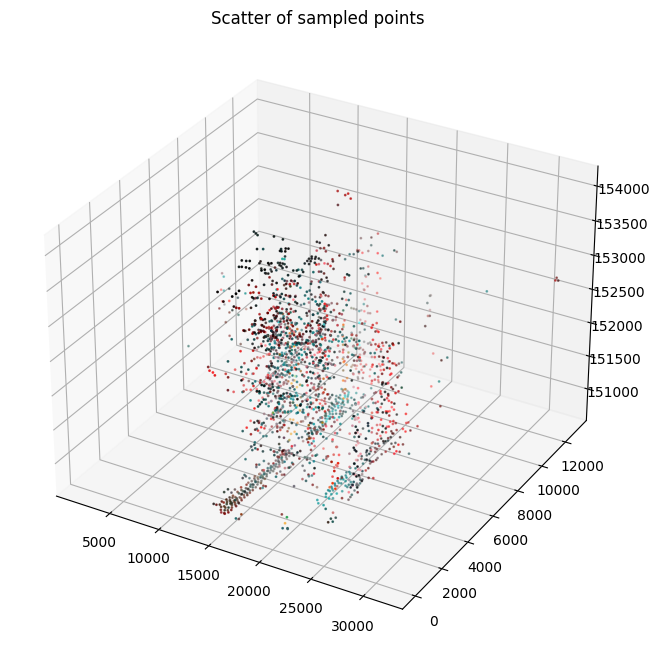

In [12]:
x_sample = x_0[point_idx[0]]

x_sample_pos = x_sample[:, :3]
x_sample_rgb = x_sample[:, 3:6] / 255.0
x_sample_int = x_sample[:, 6:] / 255.0

x = x_sample_pos[:, 0]
y = x_sample_pos[:, 1]
z = x_sample_pos[:, 2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c=x_sample_rgb, s=1)

plt.title("Scatter of sampled points")
plt.show()

### Preprocess multiple files

We should also check if there are duplicate points, because I think that if the position is global then there should be some duplicates between some sensors.

In [5]:
_, x_0 = load_data.read_x_plyfile(os.path.join(xtrain_path, "SCAN_0.ply"))
_, x_1 = load_data.read_x_plyfile(os.path.join(xtrain_path, "SCAN_1.ply"))
_, x_2 = load_data.read_x_plyfile(os.path.join(xtrain_path, "SCAN_2.ply"))

x = np.concatenate((x_0, x_1, x_2), axis=0)

In [6]:
u, c = np.unique(x, return_counts=True, axis=0)
dup = u[c > 1]

In [7]:
print(f"The percentage of unique points in the first 3 scans if {u.shape[0] / x.shape[0]}")
print(f"We have {dup.shape[0]} duplicate points")

The percentage of unique points in the first 3 scans if 0.9972706979493768
We have 22671 duplicate points


Test sampling on the unique points after concatenate

In [8]:
x_u = u

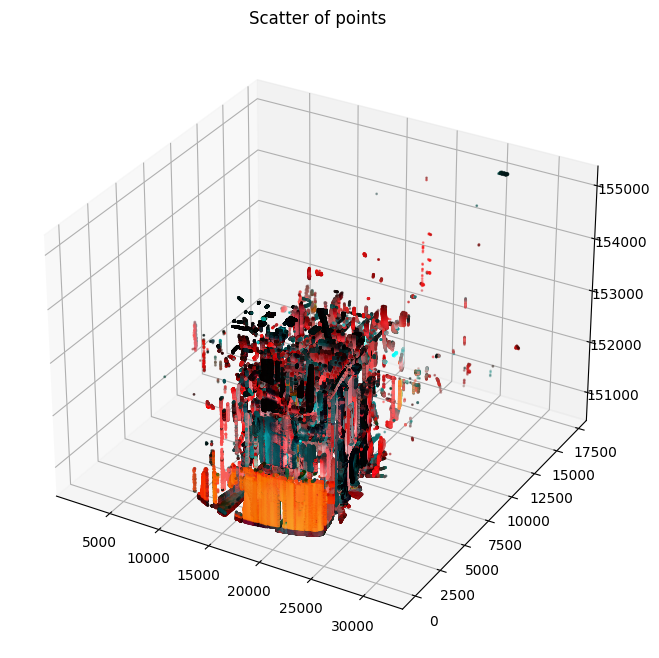

In [9]:
x_sample = x_u

x_sample_pos = x_sample[:, :3]
x_sample_rgb = x_sample[:, 3:6] / 255.0
x_sample_int = x_sample[:, 6:] / 255.0

x = x_sample_pos[:, 0]
y = x_sample_pos[:, 1]
z = x_sample_pos[:, 2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c=x_sample_rgb, s=1)

plt.title("Scatter of points")
plt.show()

In [17]:
x = torch.from_numpy(x_u[:, :3]).view(1, -1, 3)

point_idx = farthest_point_sampler(x, 2000)

point_idx

tensor([[3829656,       0,    7466,  ...,  750767, 2829668, 5060538]])

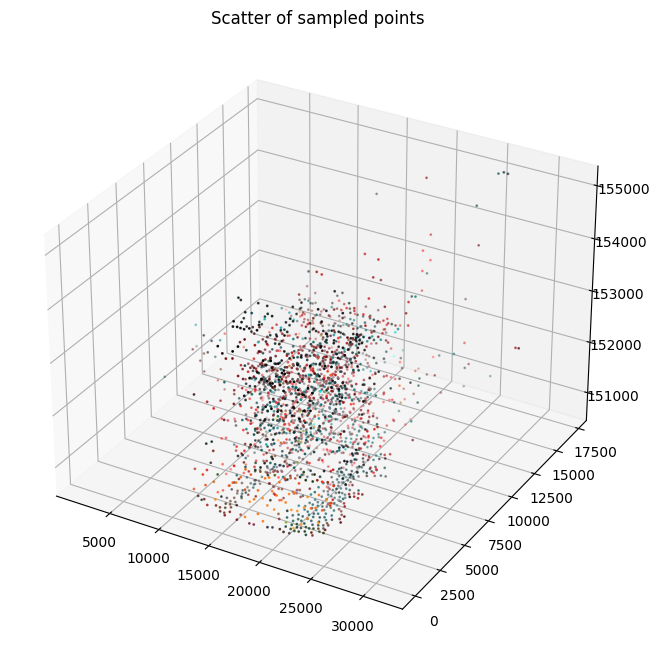

In [18]:
x_sample = x_u[point_idx[0]]

x_sample_pos = x_sample[:, :3]
x_sample_rgb = x_sample[:, 3:6] / 255.0
x_sample_int = x_sample[:, 6:] / 255.0

x = x_sample_pos[:, 0]
y = x_sample_pos[:, 1]
z = x_sample_pos[:, 2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c=x_sample_rgb, s=1)

plt.title("Scatter of sampled points")
plt.show()

### Grouping Ball Query

In [19]:
tree = BallTree(x_u[:, :3])

In [20]:
dist, ind = tree.query(x_u[point_idx[0]][:, :3], k=2_000)

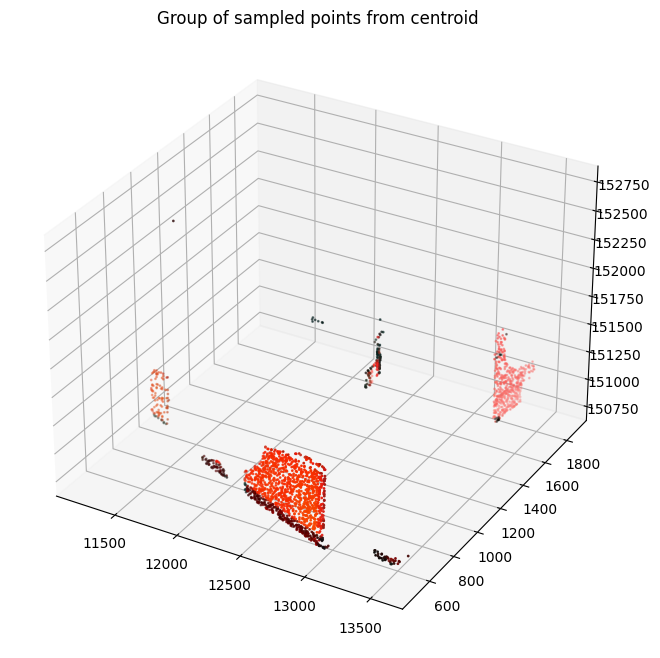

In [21]:
x_sample = x_u[ind[4]]

x_sample_pos = x_sample[:, :3]
x_sample_rgb = x_sample[:, 3:6] / 255.0
x_sample_int = x_sample[:, 6:] / 255.0

x = x_sample_pos[:, 0]
y = x_sample_pos[:, 1]
z = x_sample_pos[:, 2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c=x_sample_rgb, s=1)

plt.title("Group of sampled points from centroid")
plt.show()

### Preprocess All Files

This is a test to see if the dataset fits in the RAM memory to preprocess it. Otherwise it is fine to load file by file I think, as long as we use Ball Query with PointNet.

In [22]:
x = load_data.load_xfile(xtrain_path)

In [23]:
for k in x:
    print(x[k].shape, end=" ")

print()
print(f"The number of training sensors is {len(x)}")

(2510506, 7) (2692485, 7) (1855718, 7) (2920085, 7) (3068321, 7) (2511601, 7) (2816926, 7) (2020159, 7) (2938211, 7) (2845615, 7) (3021380, 7) (3316643, 7) (3052093, 7) (2731814, 7) (1916937, 7) (4132927, 7) (1926382, 7) (2717336, 7) (2548038, 7) (3047553, 7) (2836820, 7) (2965209, 7) (3095372, 7) (2194682, 7) (2301629, 7) (2700715, 7) (2855817, 7) (2365847, 7) (2218776, 7) (3146511, 7) (2271049, 7) (2172809, 7) (1664010, 7) (2159010, 7) (2368290, 7) (2406239, 7) (1612043, 7) (2668375, 7) (1971824, 7) (2555178, 7) (3163014, 7) (2644682, 7) (2488320, 7) (1654791, 7) (3452474, 7) (3069661, 7) (2858366, 7) (2627163, 7) (2240563, 7) (3342021, 7) 
The number of training sensors is 50


In [24]:
del x
import gc
gc.collect()

105

It seems like loading all the sensors is doable, but I think that since we only train on knn clusters we might aswell just load a single sensor at a time, or use some sort of a lazy loading, to not use all the RAM, right now it is at like 87% on 8GB. Probably will create a PyTorch Dataset that iterates the files one by one in the get method.